# **Reto 1: Cartografía Automatizada**


---



## Importar librerías

In [ ]:
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        print(e)

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import activations
from tensorflow.keras.layers import Add
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, BatchNormalization, ReLU, Add, Dropout, Concatenate, GroupNormalization
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from sklearn.metrics import f1_score
from keras.metrics import Recall, F1Score, Precision, IoU
import sklearn.metrics
import tensorflow.keras.backend as K
from PIL import Image
import cv2
from google.colab.patches import cv2_imshow
import random
from tensorflow.keras.optimizers import Adam

## Montar el drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Cargar el dataset

In [ ]:
base_dir = '/content/drive/MyDrive/HACKATHON/Dataset segmentacion'

train_images = []

for filename in sorted(os.listdir(base_dir)):
  if filename.endswith('.png'):
    image_path = os.path.join(base_dir, filename)
    image = cv2.imread(image_path) # Leer las imágenes
    image = cv2.resize(image, (256, 256)) # Cambiar el tamaño de las imágenes
    image = image / 255.0 # Normalizar las imágenes
    train_images.append(image)

train_images = np.array(train_images)

train_masks = []

for filename in sorted(os.listdir(base_dir)):
    if filename.endswith('.npy'):
        mask_path = os.path.join(base_dir, filename)
        mask = np.load(mask_path).astype(np.float32) # Cargar las máscaras
        mask= cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)  #Cambiar el tamaño de las máscaras
        train_masks.append(mask)

train_masks = np.array(train_masks)


## Dividir datos de train y test

In [ ]:
train_images, test_images, train_masks, test_masks = train_test_split(train_images, train_masks, test_size=0.1, random_state=42)

## Funciones para aumento de datos

In [ ]:
# Aplicar resize a las imágenes y máscaras
def resize(image, mask, height, width):
  image = tf.image.resize(image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  mask = tf.image.resize(mask, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return image, mask

In [ ]:
# Realizar cortes aleatorios a las imágenes y máscaras
@tf.function
def random_crop(image, mask):
    image, mask = resize(image, mask, 300, 300)
    cropped_image = tf.image.random_crop(image, size=[256, 256, tf.shape(image)[-1]])
    cropped_mask = tf.image.random_crop(mask, size=[256, 256, tf.shape(mask)[-1]])
    return cropped_image, cropped_mask

# Rotar y reflejar las imágenes horizontal/verticalmente
@tf.function
def random_jitter(image, mask):

    image, mask = random_crop(image, mask)
    if tf.random.uniform(()) > 0.4:
        rotacion = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
        image = tf.image.rot90(image, k=rotacion)
        mask = tf.image.rot90(mask, k=rotacion)
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)

    return image, mask



In [ ]:
# Aplicar las transformaciones
def data_augmentation(images, masks):
    augmented_images = []
    augmented_masks = []

    for i in range(images.shape[0]):
        aug_image, aug_mask = random_jitter(images[i], masks[i])
        augmented_images.append(aug_image)
        augmented_masks.append(aug_mask)

    augmented_images = np.array(augmented_images)
    augmented_masks = np.array(augmented_masks)

    return augmented_images, augmented_masks

In [ ]:
transformed_images, transformed_masks = data_augmentation(train_images, train_masks)

# Añadir las imágenes y máscaras transformadas al conjunto de datos
train_images = np.concatenate((train_images, transformed_images), axis=0)
train_masks = np.concatenate((train_masks, transformed_masks), axis=0)

transformed_images, transformed_masks =  data_augmentation(test_images, test_masks)
test_images = np.concatenate((test_images, transformed_images), axis=0)
test_masks = np.concatenate((test_masks, transformed_masks), axis=0)

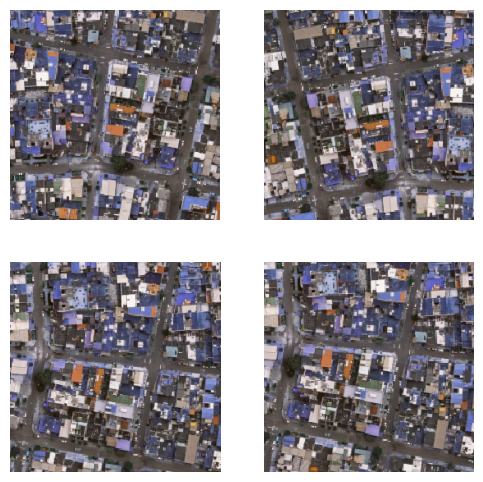

In [ ]:
plt.figure(figsize=(15, 5))
for i in range(4):
  rj_image, rj_mask = random_jitter(train_images[0], train_masks[0])
  plt.subplot(2, 4, i + 1)
  plt.imshow(rj_image, cmap='gray')
  plt.axis('off')
plt.show()

## Plotear datos

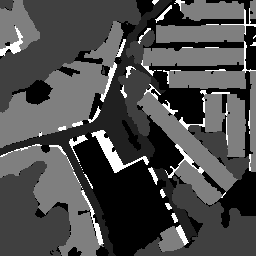

In [ ]:
mascara = train_masks[56]

# Obtener cada canal por separado
# Obtener cada canal por separado
canal_1 = mascara[:, :, 0]
canal_2 = mascara[:, :, 1]
canal_3 = mascara[:, :, 2]
canal_4 = mascara[:, :, 3]

# Crear una matriz con ceros del mismo tamaño que la imagen original
resultado = np.zeros_like(canal_1)

# Asignar colores a cada segmentación
resultado[canal_1 == 1] = 255  # Asignar un color para la segmentación del canal 1
resultado[canal_2 == 1] = 127  # Asignar un color para la segmentación del canal 2
resultado[canal_3 == 1] = 64   # Asignar un color para la segmentación del canal 3
resultado[canal_4 == 1] = 32   # Asignar un color para la segmentación del canal 4


# Mostrar la imagen resultante en Google Colab
cv2_imshow(resultado)


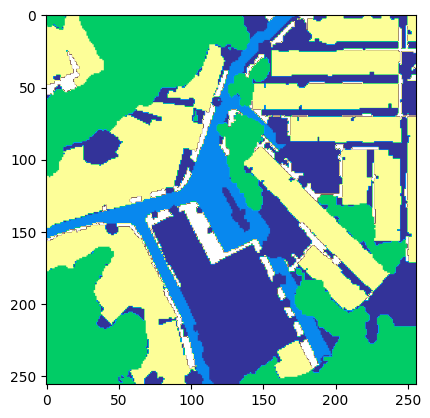

In [ ]:
plt.imshow(resultado,cmap='terrain')

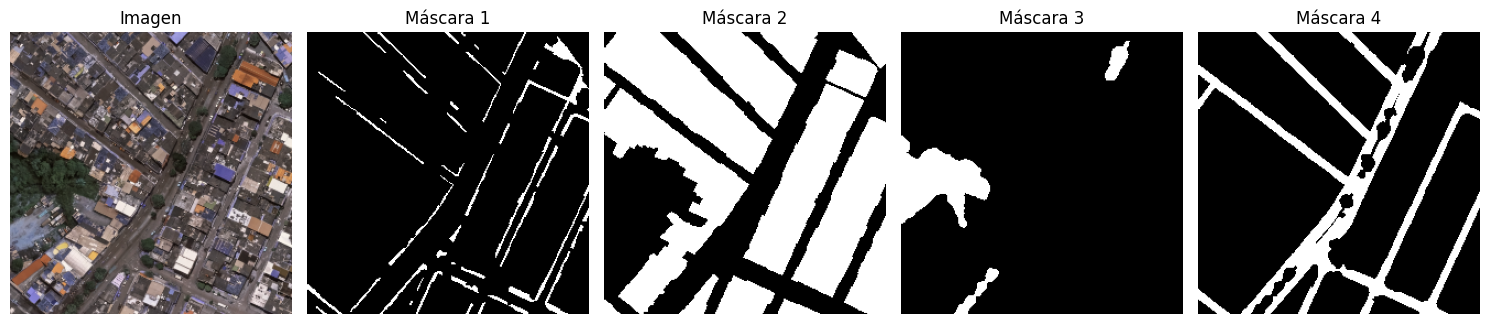

In [ ]:
plt.figure(figsize=(15, 5))
idx = 83
plt.subplot(1, 5, 1)
plt.imshow(train_images[idx])
plt.title('Imagen')
plt.axis('off')

for i in range(4):
    plt.subplot(1, 5, i + 2)
    plt.imshow(train_masks[idx][:, :, i], cmap='gray')
    plt.title(f'Máscara {i + 1}')
    plt.axis('off')

plt.tight_layout()
plt.show()

### Definir el modelo

In [ ]:
def unet(input_shape=(256, 256, 3)):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(64, 3, padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = tf.keras.layers.LeakyReLU(alpha=0.01)(conv1)
    conv1 = Conv2D(64, 3, padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = tf.keras.layers.LeakyReLU(alpha=0.01)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = tf.keras.layers.LeakyReLU(alpha=0.01)(conv2)
    conv2 = Conv2D(128, 3, padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = tf.keras.layers.LeakyReLU(alpha=0.01)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = tf.keras.layers.LeakyReLU(alpha=0.01)(conv3)
    conv3 = Conv2D(256, 3, padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = tf.keras.layers.LeakyReLU(alpha=0.01)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Middle

    emb = Conv2D(512, 3, padding='same')(pool3)
    emb = BatchNormalization()(emb)
    emb = tf.keras.layers.LeakyReLU(alpha=0.01)(emb)
    emb = Conv2D(512, 3, padding='same')(emb)
    emb = BatchNormalization()(emb)
    emb = tf.keras.layers.LeakyReLU(alpha=0.01)(emb)

    # Decoder
    up5 = Conv2DTranspose(256, (2,2), strides=2, padding="same")(emb)
    up5 = Concatenate()([conv3, up5])
    up5 = Conv2D(256, 3, padding='same')(up5)
    up5 = BatchNormalization()(up5)
    conv5 = Conv2D(256, 3, padding='same')(up5)
    conv5 = BatchNormalization()(conv5)

    up6 = Conv2DTranspose(128, (2,2), strides=2, padding="same")(conv5)
    up6 = Concatenate()([conv2, up6])
    up6 = Conv2D(128, 2, padding='same')(up6)
    up6 = BatchNormalization()(up6)
    up6 = tf.keras.layers.LeakyReLU(alpha=0.01)(up6)
    conv6 = Conv2D(128, 3, padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = tf.keras.layers.LeakyReLU(alpha=0.01)(conv6)

    up7 = Conv2DTranspose(64, (2,2), strides=2, padding="same")(conv6)
    up7 = Concatenate()([conv1, up7])
    up7 = Conv2D(64, 3, padding='same')(up7)
    up7 = BatchNormalization()(up7)
    up7 = tf.keras.layers.LeakyReLU(alpha=0.01)(up7)
    conv7 = Conv2D(64, 3, padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = tf.keras.layers.LeakyReLU(alpha=0.01)(conv7)

    outputs = Conv2D(4, (1,1), activation='sigmoid', padding="same")(conv7)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

unet_model = unet()
unet_model.summary()

## Compilar y entrenar el modelo

In [ ]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss
def bce_dice_loss(y_true, y_pred):
    loss = losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

In [ ]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(), loss=bce_dice_loss, metrics=['accuracy'])

In [ ]:
history = unet_model.fit(train_images, train_masks, batch_size=16, epochs=200, validation_split=0.1)

Epoch 1/200
11/11 [==============================] - 16s 362ms/step - loss: 2.8511 - accuracy: 0.5222 - val_loss: 1.1613 - val_accuracy: 0.4544
Epoch 2/200
11/11 [==============================] - 2s 216ms/step - loss: 1.0453 - accuracy: 0.5242 - val_loss: 1.0892 - val_accuracy: 0.4555
Epoch 3/200
11/11 [==============================] - 2s 216ms/step - loss: 1.0114 - accuracy: 0.5245 - val_loss: 1.0834 - val_accuracy: 0.4555
Epoch 4/200
11/11 [==============================] - 2s 216ms/step - loss: 0.9989 - accuracy: 0.5245 - val_loss: 1.0982 - val_accuracy: 0.4555
Epoch 5/200
11/11 [==============================] - 2s 217ms/step - loss: 0.9875 - accuracy: 0.5245 - val_loss: 1.0805 - val_accuracy: 0.4555
Epoch 6/200
11/11 [==============================] - 2s 216ms/step - loss: 0.9534 - accuracy: 0.5438 - val_loss: 1.1514 - val_accuracy: 0.4678
Epoch 7/200
11/11 [==============================] - 2s 216ms/step - loss: 0.9139 - accuracy: 0.5812 - val_loss: 1.0670 - val_accuracy: 0.485

### Plotear predicciones del modelo

1/1 [==============================] - 2s 2s/step


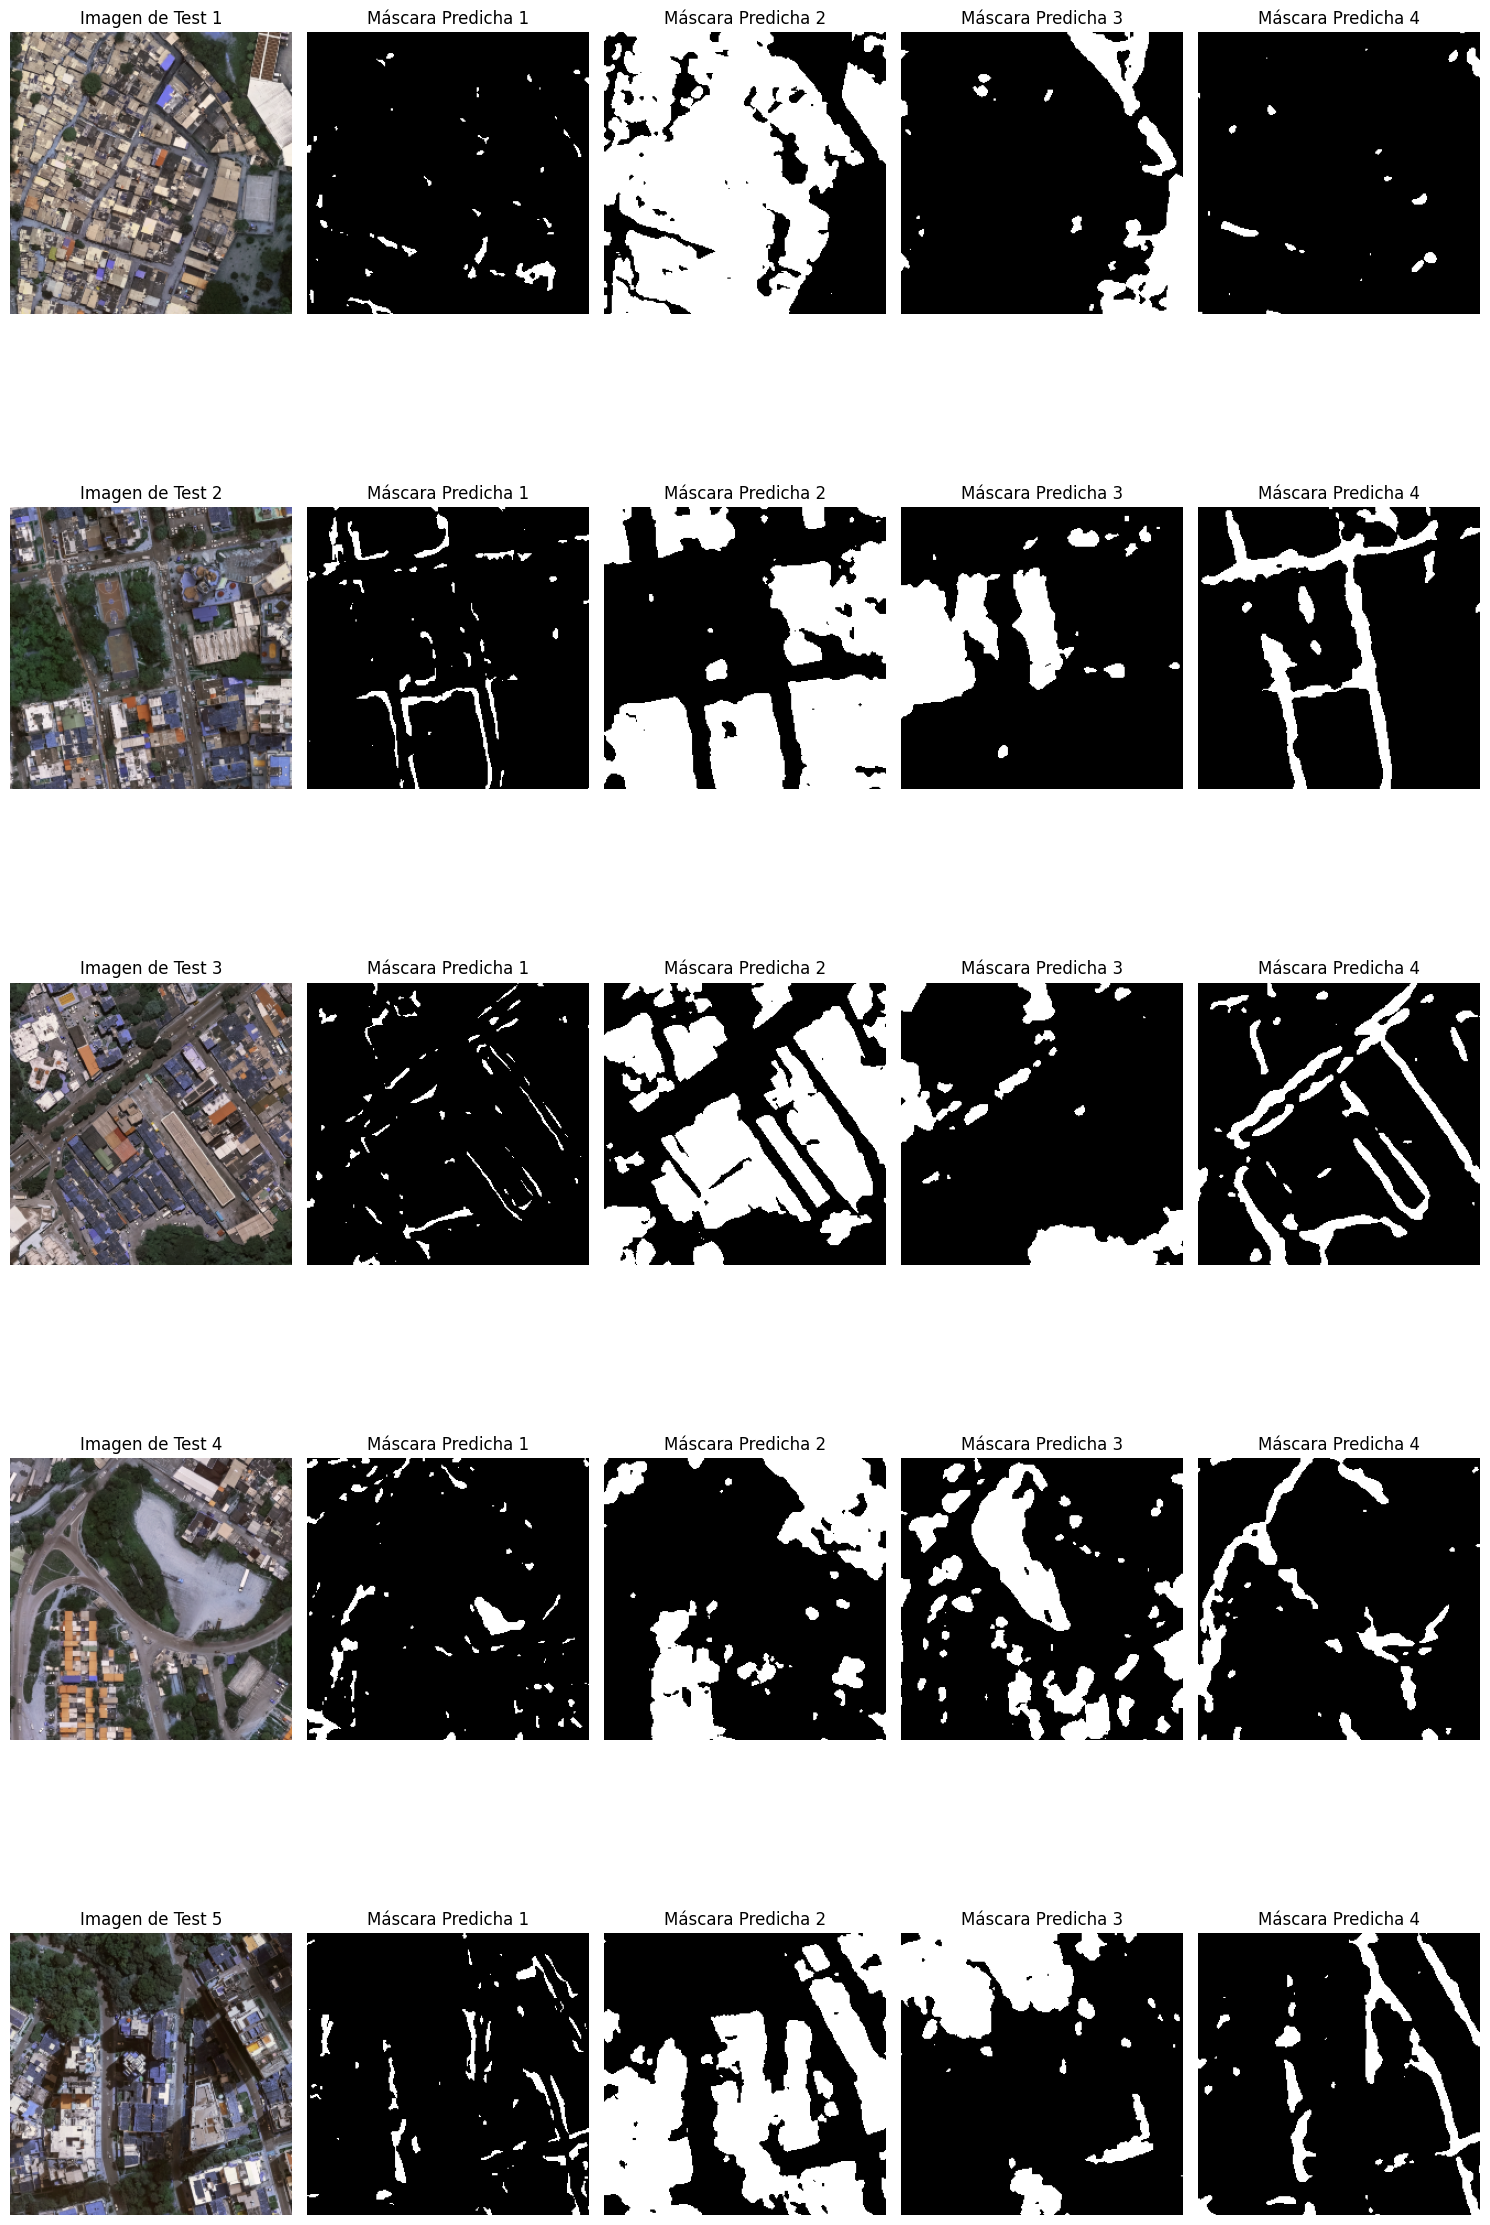

In [ ]:
predicted_masks = unet_model.predict(test_images)
predicted_masks = (predicted_masks > 0.2)

plt.figure(figsize=(15, 5 * 5))

for i in range(5):
    plt.subplot(5, 5, 5 * i + 1)
    plt.imshow(test_images[i])
    plt.title(f'Imagen de Test {i+1}')
    plt.axis('off')

    for j in range(4):
        plt.subplot(5, 5, 5 * i + j + 2)
        plt.imshow(predicted_masks[i, :, :, j], cmap='gray')
        plt.title(f'Máscara Predicha {j + 1}')
        plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
def calculate_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    iou = np.sum(intersection) / np.sum(union)

    return iou

preds_train = unet_model.predict(train_images, verbose=1)
preds_val = unet_model.predict(test_images, verbose=1)

preds_train_t = (preds_train > 0.2).astype(np.uint8)
preds_val_t = (preds_val > 0.2).astype(np.uint8)


dice = f1_score(test_masks.flatten(), preds_val_t.flatten(), pos_label=1 )

acc = accuracy_score(test_masks.flatten(), preds_val_t.flatten())
iou = calculate_iou(test_masks.flatten(), preds_val_t.flatten())
print("Dice_score:", dice,
      "\nAccuracy:", acc,
      "\nIoU:", iou)

1/1 [==============================] - 0s 28ms/step
Dice_score: 0.6452604929626745 
Accuracy: 0.8539972305297852 
IoU: 0.4762985722427126
